In [1]:
from typing import List
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from dataclasses import asdict
import pandas as pd

import matplotlib.pyplot as plt


import torch

from chinese_checkers.simulation import GameSimulation, S3SimulationCatalog 
from chinese_checkers.model.BootstrapModel import BootstrapModel
from chinese_checkers.experience import ExperienceData, S3ExperienceCatalog, ExperienceMetadata

from chinese_checkers.cnn import CnnEncoderExperience, CnnEncoderState, CnnEncoderMove, DqlCnnAgent, DqlCnnModel

print("CUDA Available:", torch.cuda.is_available())

def print_err(error_values):
    epochs = [entry['epoch'] for entry in error_values]
    test_errors = [entry['test_error'] for entry in error_values]
    validation_errors = [entry['validation_error'] for entry in error_values]
    validation_errors_discounted = [entry['validation_error_discounted_returns'] for entry in error_values]
    
    # Plotting the lines with different styles
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, test_errors, label='Test Error', linestyle=':', marker='o')
    plt.plot(epochs, validation_errors, label='Validation Error', linestyle='--')
    plt.plot(epochs, validation_errors_discounted, label='Validation Error (Discounted Returns)', linestyle='-')
    
    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Error Value')
    plt.title('Error Values over Epochs')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'training-error-{model_version}.png')
    plt.show()

CUDA Available: True


In [2]:
generator_name="CnnExperienceEncoder-v005"

catalog = S3ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
pd.DataFrame([asdict(m) for m in dataset_metadata if m.generator_name == generator_name])

,player_count,board_size,max_game_length,winning_player,name,version,generator_name,current_player
0,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
1,2,4,1000,0,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
2,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,0
3,2,4,1000,3,bad-player-3-bootstrap-simulation,v0.0.1,CnnExperienceEncoder-v005,3
4,2,4,1000,0,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v005,0
5,2,4,1000,0,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v005,3
6,2,4,1000,3,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v005,0
7,2,4,1000,3,bootstrap-p3-010-simulation,v0.0.1,CnnExperienceEncoder-v005,3
8,2,4,1000,0,bootstrap-simulation-p0d05-p0d25,v0.0.1,CnnExperienceEncoder-v005,0
9,2,4,1000,0,bootstrap-simulation-p0d05-p0d25,v0.0.1,CnnExperienceEncoder-v005,3


In [3]:
player_count = 2
current_player = "0"
board_size = 4

In [4]:
# Initialize tqdm with detailed postfix for metadata info
experiences: List[ExperienceData] = []
progress_bar = tqdm(dataset_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, generator=metadata.generator_name, total=len(experiences))
    
    if (
        metadata.player_count == str(player_count)
        and metadata.current_player == current_player
        and metadata.generator_name == generator_name
        and metadata.board_size == str(board_size)
    ):
        experiences.extend(catalog.load_random_batch(metadata,1))

print(f"Found {len(experiences)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s, generator=CnnExperienceEncoder-v005, name=bootstrap-0d01-vs-dql-v004, total=3418]       

Found 3418 datasets for player_count: 2, and current_player: 0.


In [5]:
from collections import defaultdict

def limit_duplicates(experiences, max_count):
    # Dictionary to count occurrences
    occurrence_count = defaultdict(int)
    
    # List to hold filtered experiences
    filtered_experiences = []
    
    for experience in experiences:
        # Only add experience if it hasn't reached the max_count
        if occurrence_count[experience.action_hash()] < max_count:
            filtered_experiences.append(experience)
            occurrence_count[experience.action_hash()] += 1
            
    return filtered_experiences
max_count = 1
filtered_experiences = limit_duplicates(experiences, max_count)
print(f"Found {len(filtered_experiences)} experiences after removing duplicates with limit {max_count}")

Found 3418 experiences after removing duplicates with limit 1


In [6]:
len(limit_duplicates([experiences[0], experiences[0]], 1))

1

In [7]:
p0_win_count = len([e for e in experiences if e.metadata.winning_player =="0"])
p3_win_count = len([e for e in experiences if e.metadata.winning_player =="3"])
no_win_count = len([e for e in experiences if not e.metadata.winning_player in ["0", "3"]])

print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}, no_win_count {no_win_count}")

p0_win_count 1474, p3_win_count 1944, no_win_count 0


In [8]:
sim_catalog = S3SimulationCatalog()
sim_metadata: List[GameSimulation] = [
    m 
    for m in sim_catalog.list_datasets()
    if m.winning_player in ["0", "3"]
        and m.name == "bootstrap-simulation-short"
]
pd.DataFrame([asdict(m) for m in sim_metadata])

,player_count,board_size,max_game_length,winning_player,name,version
0,2,4,200,0,bootstrap-simulation-short,v0.0.1
1,2,4,200,3,bootstrap-simulation-short,v0.0.1


In [9]:
simulations: List[GameSimulation] = []
progress_bar = tqdm(sim_metadata, desc="Loading datasets")

for metadata in progress_bar:
    # Dynamically set postfix with metadata name and generator name
    progress_bar.set_postfix(name=metadata.name, total=len(simulations))
    simulations.extend(sim_catalog.load_dataset(metadata))

print(f"Found {len(simulations)} datasets for player_count: {player_count}, and current_player: {current_player}.")

Loading datasets: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, name=bootstrap-simulation-short, total=177]

Found 359 datasets for player_count: 2, and current_player: 0.


In [10]:
state_encoder = CnnEncoderState(board_size)
move_encoder = CnnEncoderMove(board_size)
cnn_encoder = CnnEncoderExperience("v005")
model_version = "v005"
# Define model parameters
gamma = 0.99
lr = 0.0001
batch_size = 2**7
model_save_path = f"dql_cnn_model_{model_version}.pth"

Starting training...


Training Progress:   0%|          | 0/20 [01:14<?, ?it/s, Test Error=0.5073, Validation Error=0.5237, Validation Error (Discounted)=1871887.5552]

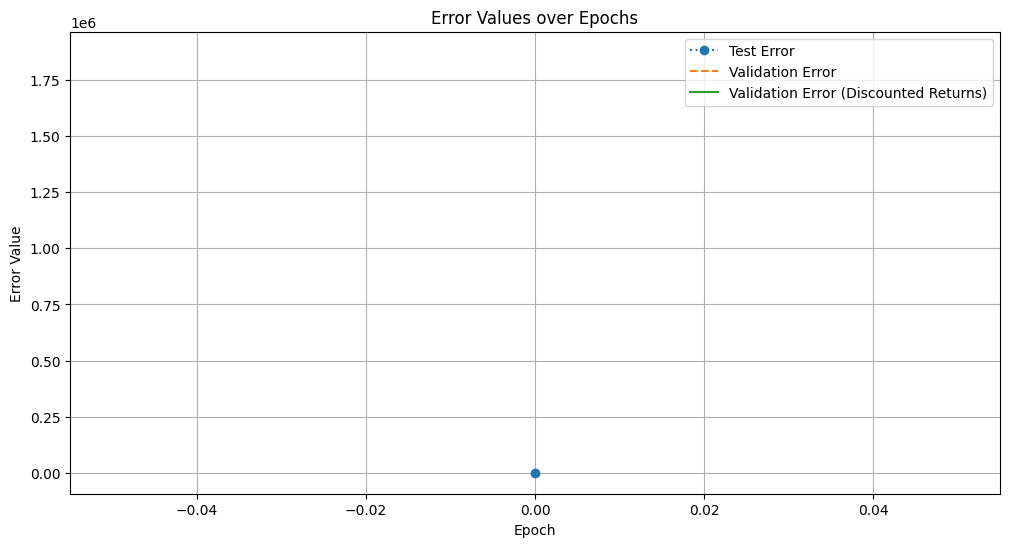

Training Progress:   5%|▌         | 1/20 [01:14<23:36, 74.57s/it, Test Error=0.5073, Validation Error=0.5237, Validation Error (Discounted)=1871887.5552]

In [ ]:
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets (80/20 split)
experience_datas = [e.data for e in experiences]
train_experiences, test_experiences = train_test_split(experience_datas, test_size=0.2, random_state=42)

# Initialize the agent
agent = DqlCnnAgent(
    state_encoder=state_encoder,
    move_encoder=move_encoder,
    experience_encoder = cnn_encoder,
    gamma=gamma,
    lr=lr,
    batch_size=batch_size
)

# List to store error metrics from each epoch
error_values = []

# Training loop with validation at each epoch
print("Starting training...")
num_epochs = 20
with tqdm(range(num_epochs), desc="Training Progress") as epoch_bar:
    for epoch in epoch_bar:
        # Shuffle training data each epoch for better generalization
        random.shuffle(train_experiences)
        
        # Training phase
        for i in range(0, len(train_experiences), batch_size):
            batch_experiences = train_experiences[i:i + batch_size]
            for experience in batch_experiences:
                agent.store_experience(experience)  # Store each experience in the batch
            agent.train()  # Train on the batch

        # Validation phase
        results = agent.validate(
            test_set=test_experiences, 
            validation_set=train_experiences, 
            validation_simulations=simulations
        )
        
        # Append validation results to error_values list
        error_values.append({
            "epoch": epoch,
            "test_error": results['test_error'],
            "validation_error": results['validation_error'],
            "validation_error_discounted_returns": results['validation_error_discounted_returns']
        })
        
        # Update progress bar with current errors
        epoch_bar.set_postfix({
            "Test Error": f"{results['test_error']:.4f}",
            "Validation Error": f"{results['validation_error']:.4f}",
            "Validation Error (Discounted)": f"{results['validation_error_discounted_returns']:.4f}"
        })
        
        # Save the model at each epoch
        agent.save(model_save_path)
        print_err(error_values)

# Save the trained model with all components
print(f"Model and components saved to {model_save_path}")


---

dql_cnn_model_v003.pth
Training Progress: 100%|██████████| 120/120 [19:31:46<00:00, 585.89s/it, Test Error=17.5490, Validation Error=17.5443, Validation Error (Discounted)=538.4413]

---



In [ ]:
# model_1 = BootstrapModel()
model_1 = DqlCnnModel(
    model_path=model_save_path,                          
    board_size=4                               
)

# model_2 = DqlCnnModel(
#     model_path=model_save_path,                          
#     board_size=4                               
# )
model_2 = BootstrapModel()


# Simulate the game using the models
game_simulation = GameSimulation.simulate_game(
    models=[model_1, model_2],  # DQL model plays against the bootstrap model
    name=f"dql_cnn_vs_bootstrap_{model_version}_simulation",
    version="v1.0.0",
    print_period=500,
    show_coordinates=True,
    max_turns=1000
)


In [ ]:
game_simulation.display()

In [ ]:
game_sequence = game_simulation._to_game_sequence()
for i, (move, game) in enumerate(zip(game_simulation.data.historical_moves, game_sequence)):
    print(f"\nCurrent Player: {game.get_current_player().player_id} \n{move}\nTurn: {i}")
    game.print()
    if i > 20:
        break